# Problem Definition

With our current subscription plan to the Simplybook.me, we have 1200 bookings available per year. Last year and this year, we exceeded this figure. We would like to figure out the most feasible way to find our way around this problem and upgrade our subscription, if necessary.

In [1]:
import pandas as pd
import numpy as np
import os
from scipy import stats

import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("darkgrid")

pd.set_option("display.max_columns", None)

df = pd.read_csv("./bookings.csv", parse_dates = ["Date", "Record date"]) # From 05.10.2020 until 05.10.2021

In [2]:
keep = ["Date", "Time", "Service", "Code", "Client name", "Client email", 
        "Record date", "Is cancelled", "Cancellation time", "Number of changes", "Matriculation Nr:", 
        "Department (Fakultät):"]

In [3]:
df = df[keep]

# Exploratory Data Analysis

In [4]:
df.shape[0]

1576

With duplicate registrations unaccounted for, we have about 1600 bookings. Our limit is 100 bookings per month, i.e. 1200 bookings per year. The exchange program application season is the most likely culprit in the surge in demand. I'm going to dive in a bit deeper to see the seasonality of the demand. 

In [5]:
df['Month'] = df.Date.dt.month_name()

In [6]:
monthlyBookings = df.groupby('Month').size().reset_index(name = 'Bookings')

sort_order = ['January', 'February', 'March', 'April', 'May','June', 'July', 
              'August', 'September', 'October', 'November', 'December']

monthlyBookings['Month'] = pd.Categorical(monthlyBookings['Month'], categories = sort_order, ordered = True)

monthlyBookings.sort_values(by = 'Month', inplace = True)

monthlyBookings

,Month,Bookings
4,January,238
3,February,40
7,March,45
0,April,135
8,May,101
6,June,84
5,July,46
1,August,99
11,September,148
10,October,169


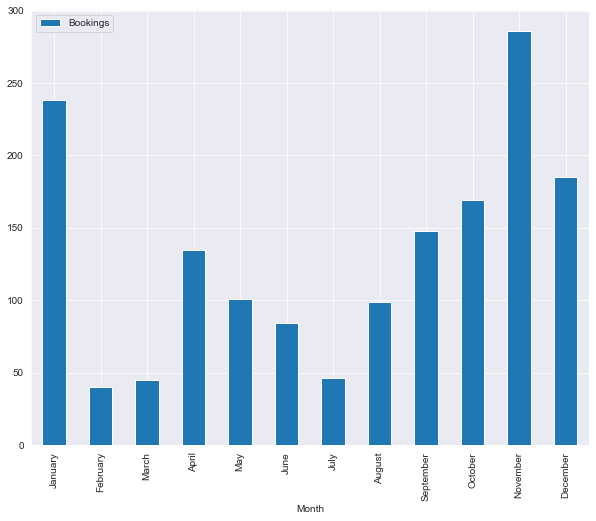

In [7]:
monthlyBookings.plot(kind = 'bar', x = 'Month', y = 'Bookings', figsize = (10,8))

plt.show()

As long as we have some bookings left in the tank, we don't need to worry about the months where we surpass the 100 bookings/month metric. There are, however, three months where demand borders on 200 bookings or exceeds it. 

We start to pick up steam around September and October and reach peak demand by November. November, December, and January are by a large margin our busies months.

If we eliminated all the duplicate bookings and made those spots available for other students who have never taken the test before, how many bookings would be enough?

In [8]:
wONr = df[df[['Client name']].duplicated()] # w/o mat nr
wONr.shape # 338 duplicates when Matr Nr is not considered

(338, 13)

In [9]:
withNr = df[df[['Client name', 'Matriculation Nr:']].duplicated()] # with mat nr
withNr.shape # 326 duplicates when Matr Nr is considered

(326, 13)

From the looks of it, some students change their matriculation numbers and register themselves twice. Some examples:

In [10]:
df1 = wONr.merge(withNr, how = 'outer' ,indicator = True).loc[lambda x : x['_merge']=='left_only']

Zoom in on the first student.

In [11]:
df[df['Client name'] == 'Jonas Böhm'].shape

(2, 13)

This could be an honest mistake as this dude who gave the wrong matriculation number, then cancelled his first booking, and changed the exam date he prefers.

When the status of the 'Is cancelled' column is taken into consideration, we get a better understanding of the situation.

In [12]:
# the total bookings - duplicates + cancelled duplicates

print(df.shape[0] - wONr.shape[0]  + (wONr['Is cancelled'] != 'Yes').sum())

1401


So, we are about 2 months above our 1200 bookings/year limit. Since we are on the subject, I'll look into how many extra bookings I can go and cancel right now. Today is the 29th of September.

I'm going to check the duplicate bookings for the upcoming exam dates that the student did not cancel.

In [13]:
wONr[(wONr.Date > pd.Timestamp.now()) & (wONr['Is cancelled'] != 'Yes')].reset_index(drop = True).shape

(23, 13)

The most exam spots I can save here are 25, which won't change much as we exceed the yearly limit by about 200 unique students.

Let's take a look at the trend in the registration figures to make a data-driven decision instead of speculating. What can we expect to happen in the future? I'm going to inspect the data from the previous years to predict the next year's bookings and determine the trend in the growth in the bookings.

In [14]:
os.chdir('./Previous_years') # this is the directory where data of the previous years are stored

The data for one year spans two years, but only three months are from the preceding year. As such, I chose to label the data as from the following year.

In [15]:
years = np.array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021])
bookings = np.array([])

for csv in os.listdir():
    csv = pd.read_csv(csv)
    bookings = np.append(bookings, csv.shape[0])

bookings = np.append(bookings, df.shape[0]) # append 2021 at the end

# Data Analysis

I will regress the bookings onto years to forecast the bookings in the year 2022 and determine the overall trend in bookings.

In [16]:
res = stats.linregress(years, bookings)

print(f"R-squared: {res.rvalue**2:.6f}") # 71% of the variance in bookings could be explained with the year variable

print(f"p-value: {res.pvalue**2:.6f}") 
# much, much lower than statistical significance threshold 1%. the relationship is statistically significant

R-squared: 0.707254
p-value: 0.000020


Let's look at the yearly trend in the bookings and then plot the regression line.

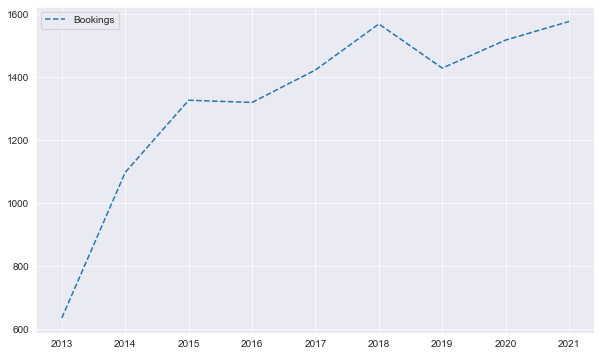

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

plt.plot(years, bookings, '--', label = 'Bookings')

plt.legend()

plt.show()

Notice the upward, (mostly) linear trend! Our bookings are definitely on the rise, and looks like the demand will only increase next year. Let's fit a regression line.

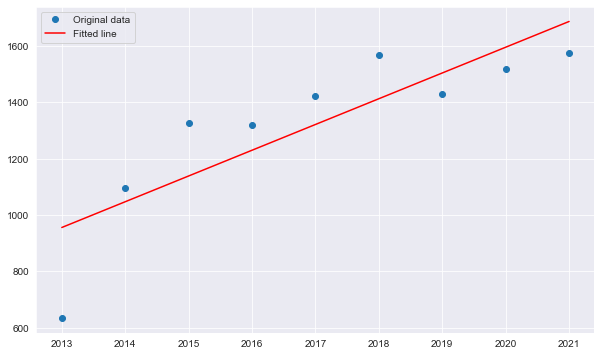

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

plt.plot(years, bookings, 'o', label = 'Original data')

plt.plot(years, res.intercept + res.slope * years, 'r', label = 'Fitted line')

plt.legend()

plt.show()

A quadratic or cubic polynomial would fit the data better, but you can easily see the trend in the bookings. Except for one year (2018), more and more students signed up for the test. It's reasonable to expect more bookings in 2022.

In [19]:
res.intercept + res.slope * 2022 

# this could be the bookings next year, 
# should be taken with a grain of salt since linear regression is not the best fit

1777.305555555533

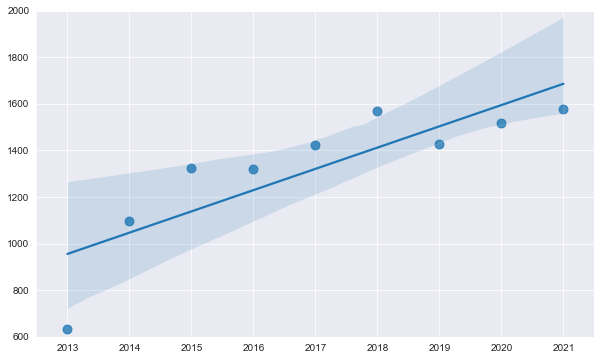

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

sns.regplot(x = years, y = bookings, scatter = True, ci = 95, scatter_kws = {"s": 80})

plt.ylim(600, 2000)
plt.xlim(2012.5, 2021.5)

# sns.despine()

plt.show()

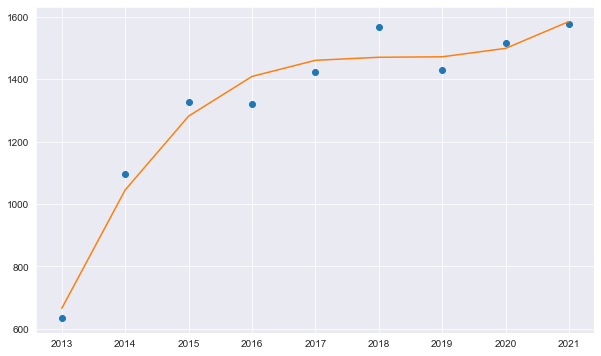

In [21]:
res1 = np.polyfit(years, bookings, 3)

p = np.poly1d(res1) # the 3rd degree polynomial

fig, ax = plt.subplots()
fig.set_size_inches(10, 6)

_ = plt.plot(years, bookings, 'o', years, p(years)) # notice the upward trend


plt.show()

# Possible Solutions

What should be done here, given that the demand will most likely increase in the upcoming years?

We currently pay 80 €/year for the basic plan, which grants us 1200 bookings per year. Even if the bookings stay constant for the next year, we will still need about 300 extra bookings to cover the demand.

Here are our options:

 - Move from basic subscription plan to standard subscription plan.
 
     - The standard subscription plan gives 500 bookings per month. We overshoot the demand by about 4000 extra bookings. We would pay 250 €/year. Extra €170 cost incurred. Not recommended.
     
 - Buy additional bookings
 
     - This one makes sense as it's cheaper than switching to the standard subscription plan. Simplybook.me sells 2000 extra bookings for €65. The amount is fixed, we can't bargain for fewer bookings and pay less. About 1700 bookings would go to waste. 
     
 - Cut some exams
 
    - This is the option that costs nothing to implement. In our three busiest months (November, December, and January) and in the run-up to these three (the month of October - 170 bookings), we could slash one week and offer three exams per month instead of weekly exams. 
     

# Takeaways

- Even when the duplicate records are removed, we are above the 1200 bookings/year threshold.
- There's a strong positive linear relationship between years vs. bookings. 
- 71% of the variation in bookings can be attributed to the years (p-value = 0.000020)
- The bookings will most likely increase next year.
- To stem the tide, we have three options:
 - Upgrade to the standard plan, waste about 4000 bookings, and pay €170 more.
 - Buy extra bookings, waste about 1700 bookings, and pay €65 more.
 - Cancel one week in each of the busiest four months, let fewer students take the test, and pay nothing.
- Plans are rigid, and there's no room for flexibility.